<a href="https://colab.research.google.com/github/bgorai005/deeplearning_assignment1/blob/main/dl_assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Name-Biswajit gorai ,Roll no- MA24M005

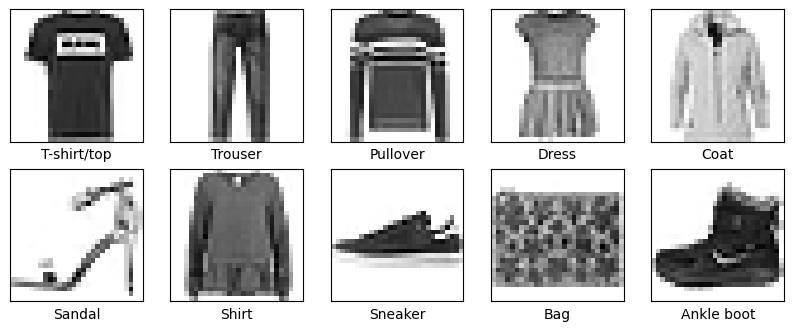

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize W&B project
wandb.init(project='deep_learning_assignment_1')

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plot 1 sample image for each class
plt.figure(figsize=(10, 10))
for label in range(10):
    sample_image = train_images[train_labels == label][0]
    plt.subplot(5, 5, label + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[label])
    plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

# Finish the W&B run
wandb.finish()


In [28]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

In [29]:
#flattenten the image data
x_train = x_train.reshape(x_train.shape[0], -1)
x_valid = x_valid.reshape(x_valid.shape[0], -1)
x_test = test_images.reshape(test_images.shape[0], -1)

In [30]:
#Normalize the image data
x_train = x_train.astype('float32') / 255
x_valid = x_valid.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [31]:
#one hot encoding for output
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded

y_train = one_hot_encode(y_train)
y_valid = one_hot_encode(y_valid)
y_test = one_hot_encode(test_labels)

In [32]:
#shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (54000, 784)
y_train shape: (54000, 10)
x_valid shape: (6000, 784)
y_valid shape: (6000, 10)


In [33]:
import numpy as np
# create a feedforward neural network
class FeedForwardNeuralNetwork:
  def __init__(self,input_size,num_layers=1,hidden_size=4,output_size=1,weight_int='random'):
    self.input_size=input_size
    self.num_layers=num_layers
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.weight_int = weight_int
    self.weights = self.initialize_weights()

  def initialize_weights(self):
    network_size=[]
    for i in range(self.num_layers):
      network_size.append(self.hidden_size)
    network_size=[self.input_size]+network_size+[self.output_size]
    weights={}
    for i in range(1,self.num_layers+2):
     if self.weight_int=='random':
      weights[f'w{i}']=np.random.randn(network_size[i],network_size[i-1])
      weights[f'b{i}']=np.random.randn(network_size[i],1)
     elif self.weight_int=='xavier':
      weights[f'w{i}']=np.random.rand(network_size[i],network_size[i-1])*np.sqrt(2/network_size[i-1])
      weights[f'b{i}']=np.random.rand(network_size[i],1)*np.sqrt( 2/network_size[i-1])

    return weights


  def sigmoid(self,x):
    return 1/(1+np.exp(-x))


  def softmax(self,x):
    x=x-np.max(x)
    return np.exp(x)/np.sum(np.exp(x))


  def forward_prop(self,x):
    a={}
    h={'h0':x}

    for i in range(1,self.hidden_size+1):
      a[f'a{i}']=np.dot(self.weights[f'w{i}'],h[f'h{i-1}'])+self.weights[f'b{i}']
      h[f'h{i}']=self.sigmoid(a[f'a{i}'])
    a[f'a{self.hidden_size+1}']=np.dot(self.weights[f'w{self.hidden_size+1}',h[f'h{self.hidden_size}']])  +self.weights[f'b{self.hidden_size+1}']
    y_pred=self.softmax(a[f'a{self.hidden_size+1}'])
    return a,h,y_pred

  def back_prop(self,x,y_actual,theta,input_size):
    m=x.shape[0]
    a,h,y_pred=self.forward_prop(x,theta,self.num_layers,self.input_size)
    grad_theta={}
    grad_h_a={}
    grad_h_a[f'a{self.num_layers+1}']=-1*(y_actual-y_pred)
    for i in range(self.num_layers+1,0,-1):
      grad_theta[f'w{i}']=np.dot(grad_h_a[f'a{i}'],h[f'h{i-1}'].T)*(1/m)
      grad_theta[f'b{i}']=np.mean(grad_h_a[f'a{i}'],axis=1,keepdims=True)*(1/m)
      grad_h_a[f'h{i-1}']=np.dot(self.weights[f'w{i}'].T,grad_h_a[f'a{i}'])
      grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*(self.der_sigmoid(h[f'h{i-1}']))
    return grad_theta




firstnetwork=FeedForwardNeuralNetwork(input_size=784,num_layers=3,hidden_size=32,output_size=10,weight_int='random')
print(firstnetwork.weights.keys())


dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])


Intialize a network

In [34]:
def initial_weight(num_layer, hidden_size, weight_ini_method):
  network_size=[]
  for i in range(num_layer):
    network_size.append(hidden_size[i])
  network_size=[x_train.shape[1]]+network_size+[y_train.shape[1]]
  print(network_size)
  theta={}
  if weight_ini_method=="random":
    for i in range(len(network_size)-1):
      theta[f'W{i+1}']=np.random.randn(network_size[i],network_size[i+1])
      theta[f'b{i+1}']=np.random.randn(1,network_size[i+1])
  if weight_ini_method=="Xavier":
    for i in range(len(network_size)-1):
      theta[f'W{i+1}']=np.random.randn(network_size[i],network_size[i+1])*(np.sqrt(2/(network_size[i])))
      theta[f'b{i+1}']=np.random.randn(1,network_size[i+1])*(np.sqrt(2/(network_size[i])))
  return theta


*Activation functiont**

In [35]:
def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x,axis=1,keepdims=True)
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)




def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  elif activ_fun=='softmax':
    return softmax(x)
  else:
    return tanh(x)

def deriv_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)


Loss function

In [36]:
def cross_entropy(y_actual, y_pred):
   epsilon = 1e-15  # to prevent log(0) which is undefined
   y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
   loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=1))
   return loss


In [37]:
def forward_prop(X, theta, active_fun_hidden, active_fun_output, num_layers):

  a = {}
  h = {'h0': X}
  for i in range(1, num_layers + 1):
    a[f'a{i}'] = np.dot(h[f'h{i-1}'], theta[f'W{i}']) + theta[f'b{i}']
    h[f'h{i}'] = activation(a[f'a{i}'], active_fun_hidden)
  a[f'a{num_layers+1}'] = np.dot(h[f'h{num_layers}'], theta[f'W{num_layers+1}']) + theta[f'b{num_layers+1}']
  y_pred = activation(a[f'a{num_layers+1}'], active_fun_output)
  return a, h, y_pred


In [38]:
theta=initial_weight(5,[5]*5,"random")
_,_,y_pred=forward_prop(x_train,theta,"sigmoid",'softmax',5)
print(y_pred)

[784, 5, 5, 5, 5, 5, 10]
[[0.00264285 0.10974322 0.02964158 ... 0.05911816 0.24916442 0.00368829]
 [0.00262616 0.11320528 0.02992949 ... 0.06028976 0.24736121 0.00373784]
 [0.00265595 0.10909447 0.02970422 ... 0.05911877 0.24935161 0.00367943]
 ...
 [0.00267445 0.1095117  0.0299913  ... 0.05970226 0.24896153 0.00368706]
 [0.00265792 0.10808301 0.02965059 ... 0.05888335 0.2493473  0.00366405]
 [0.00261201 0.11559204 0.03001332 ... 0.06089415 0.24643116 0.00377088]]


Calculate accuracy

In [39]:
def cal_accuracy(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
    # Get the input size from X (number of features)
    input_size = x.shape[0]

    # Perform forward propagation to get predicted probabilities
    # We only need y_pred, so ignore other returned values with _
    _, _, y_pred = forward_prop(x, theta,
                               active_fun_hidden,active_fun_output,num_layers)

    # Get true class labels from one-hot encoded Y (index of 1 in each column)
    true_classes = np.argmax(y, axis=1)

    # Get predicted class labels from y_pred (index of max probability in each column)
    predicted_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.mean(predicted_classes == true_classes)

    return accuracy

Back_prop

In [40]:
def back_prop(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
  m=x.shape[0]
  a,h,y_pred=forward_prop(x,theta,active_fun_hidden,active_fun_output,num_layers)
  grad_theta={}
  grad_h_a={}
  grad_h_a[f'a{num_layers+1}']=-1*(y-y_pred)
  for i in range(num_layers+1,0,-1):
    grad_theta[f'W{i}']=np.dot(h[f'h{i-1}'].T,grad_h_a[f'a{i}'])
    grad_theta[f'b{i}']=np.sum(grad_h_a[f'a{i}'],axis=0,keepdims=True)
    if i>1:
      grad_h_a[f'h{i-1}']=np.dot(grad_h_a[f'a{i}'],theta[f'W{i}'].T)
      grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*deriv_activation(a[f'a{i-1}'],active_fun_hidden)
  return grad_theta

Now we again write gradient decesent algorithm compatiable with batch size ,

In [47]:
def sgd(lr, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs):
    # Initialize weights
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients and update weights
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)
            for j in range(1, num_layers + 2):
                theta[f'W{j}'] -= lr * (grad[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * grad[f'b{j}']
        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100})

    # Final test accuracy
    test_accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test Accuracy: {test_accuracy*100}')
    wandb.log({"test_accuracy": test_accuracy*100})

    # # Plot training and validation loss
    # plt.plot(train_loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta, train_loss_history, val_loss_history


Moment Gradient descent (here momentum=beta)

In [46]:
def mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] +grad[f'b{j}']

                theta[f'W{j}'] -= lr*(velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr*velocity[f'b{j}']
        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100})


    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    # # Plot training and validation loss
    # plt.plot(train_loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta, train_loss_history, val_loss_history


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[784, 10, 20, 10, 10, 19, 10]
Epoch 1, Train Loss: 1.897368039582914, Val Loss: 1.8972212023318913
Epoch 2, Train Loss: 1.5457180149827698, Val Loss: 1.5564540620478473
Epoch 3, Train Loss: 1.3559394457819056, Val Loss: 1.3706157859682753
Epoch 4, Train Loss: 1.244175385634155, Val Loss: 1.2659661444215762
Epoch 5, Train Loss: 1.1749150999362754, Val Loss: 1.1930806452592464
Epoch 6, Train Loss: 1.1203733896052859, Val Loss: 1.1385653937307938
Epoch 7, Train Loss: 1.070198073339923, Val Loss: 1.0843670651447648
Epoch 8, Train Loss: 1.024649471254292, Val Loss: 1.0401750663006948
Epoch 9, Train Loss: 0.9928806808607911, Val Loss: 1.0074184732155684
Epoch 10, Train Loss: 0.9603229249276273, Val Loss: 0.9758556016207874
Test Accuracy: 60.3


**Nesterov accelerated gradient descent**

In [48]:

def nesterov_gd(lr, momentum, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, epochs):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize velocity dictionary with zeros, matching the shape of each parameter
    velocity = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # List to store loss history
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Look ahead step for Nesterov momentum
            lookahead_theta = {key: theta[key] - momentum * velocity[key] for key in theta.keys()}

            # Compute gradients using backpropagation on the lookahead parameters
            grad = back_prop(x_batch, y_batch, lookahead_theta, active_fun_hidden, active_fun_output, num_layers)

            # Update velocities and parameters with Nesterov momentum
            for k in range(1, num_layers + 2):
                # Update velocity for weights
                velocity[f'W{k}'] = momentum * velocity[f'W{k}'] + grad[f'W{k}']
                # Update weights using velocity
                theta[f'W{k}'] -= lr * velocity[f'W{k}']

                # Update velocity for biases
                velocity[f'b{k}'] = momentum * velocity[f'b{k}'] + grad[f'b{k}']
                # Update biases using velocity
                theta[f'b{k}'] -= lr * velocity[f'b{k}']

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch + 1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100})

    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    # Plot the training and validation loss
    # plt.plot(loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta, loss_history, val_loss_history


**RMS Prop**

In [49]:
def rmsprop(lr, gamma, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, epochs):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize squared gradient dictionary with zeros, matching the shape of each parameter
    squared_grad = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store training and validation loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update squared gradients and parameters with RMSprop
            for k in range(1, num_layers + 2):
                # Update squared gradient for weights
                squared_grad[f'W{k}'] = gamma * squared_grad[f'W{k}'] + (1 - gamma) * (grad[f'W{k}'] ** 2)
                # Update weights using RMSprop
                theta[f'W{k}'] -= lr * grad[f'W{k}'] / (np.sqrt(squared_grad[f'W{k}']) + epsilon)

                # Update squared gradient for biases
                squared_grad[f'b{k}'] = gamma * squared_grad[f'b{k}'] + (1 - gamma) * (grad[f'b{k}'] ** 2)
                # Update biases using RMSprop
                theta[f'b{k}'] -= lr * grad[f'b{k}'] / (np.sqrt(squared_grad[f'b{k}']) + epsilon)

       #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch + 1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100})

    # Calculate final accuracy on test set
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    # Plot training and validation loss
    # plt.plot(loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta


**ADAM**

In [ ]:
def adam(lr, beta1, beta2, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, epochs):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates
                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr * m_hat_W / (np.sqrt(v_hat_W) + epsilon)
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch + 1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100})

    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    # Plot the training and validation loss
    # plt.plot(loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta


**NDAM**

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def nadam(lr, beta1, beta2, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, epochs):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr * m_hat_W / (np.sqrt(v_hat_W) + epsilon)
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

         #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch + 1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100})

    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    # Plot the training and validation loss
    # plt.plot(loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta


**MOdel **

In [ ]:
def model_training(lr,beta,beta1,beta2,epsilon,x_train,y_train,x_valid,y_valid,optimizer,batch_size,num_layers,hidden_size,active_fun_hidden, active_fun_output, weight_ini_method, epochs):
  theta=initial_weight(num_layers,hidden_size,weight_ini_method)
  if optimizer=='sgd':
    theta=sgd(lr,x_train,y_train,x_valid,y_valid,batch_size,num_layers,hidden_size,active_fun_hidden,active_fun_output,weight_ini_method,epochs)
  elif optimizer=='momemtum':
    theta=mgd(lr,beta,x_train,y_train,x_valid,y_valid,batch_size,num_layers,hidden_size,active_fun_hidden,active_fun_output,weight_ini_method,epochs)
  elif optimizer=='nag':
    theta=nesterov_gd(lr,beta,x_train,y_train,x_valid,y_valid,batch_size,num_layers,hidden_size,active_fun_hidden,active_fun_output,weight_ini_method,epochs)
  elif optimizer=='RMSprop':
    theta=rmsprop(lr, beta, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, epochs)
  elif optimizer=='adam':
    theta=adam(lr,beta1,beta2,epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, epochs)
